# classification wikipedia talk pages

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

In [98]:
ds = pd.read_csv('../dataset/wiki/es_wiki_annotated.csv')
ds.columns

Index(['page_id', 'page_title', 'link', 'contributor', 'timestamp', 'topic',
       'raw', 'text', 'type1', 'stance1', 'sentiment1', 'type2', 'stance2',
       'sentiment2', 'type', 'stance', 'sentiment'],
      dtype='object')

In [111]:
stance_types = ds.groupby('type').size()
stance_types

type
agreement        3
content          3
criticism       20
disagreement     4
doubting         3
praise           1
references      15
statement        9
vandalism        1
dtype: int64

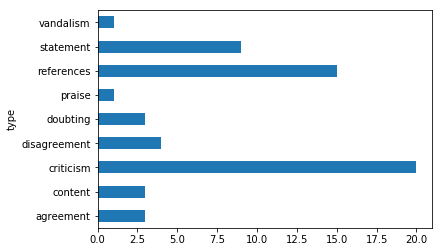

In [101]:
stance_types.plot.barh()

In [102]:
stances = ds.groupby('stance').size()
stances

stance
-1.0    29
 0.0    16
 1.0    14
dtype: int64

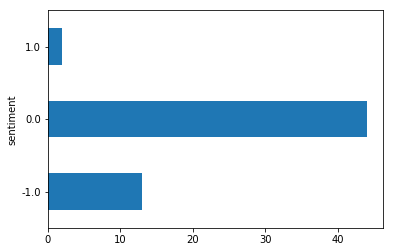

In [103]:
sentiment = ds.groupby('sentiment').size()
sentiment.plot.barh()

In [104]:
import collections
import nltk.classify.util, nltk.metrics
import nltk
from nltk import tokenize
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import movie_reviews
from nltk.corpus import stopwords
import itertools
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from nltk.probability import FreqDist, ConditionalFreqDist
from nltk.stem.snowball import SnowballStemmer

In [105]:
def get_movie_reviews_sentences(type):
    if type == 'neg':
        negids = movie_reviews.fileids('neg')
        negsentences = [movie_reviews.words(fileids=[f]) for f in negids]
        return negsentences
    else:
        posids = movie_reviews.fileids('pos')
        possentences = [movie_reviews.words(fileids=[f]) for f in posids]
        return possentences
    
def get_movie_reviews_allwords(type):

    if type == 'pos':
        words = movie_reviews.words(categories=['pos'])
        return words
    else:
        words = movie_reviews.words(categories=['neg'])
        return words

In [106]:
def preprocessing_text(tokens):
    words = [stemmer.stem(w.lower()) for w in tokens if len(w)> 3 ] #and w not in stopset]
    return words
    
def get_wikipedia_stances(type):
    if type == 'neg':
        negstances = ds[ds.stance==-1]['text'].values
        negsentences = [preprocessing_text(tokenize.word_tokenize(s)) for s in negstances]
        return negsentences
    else:
        posstances = ds[ds.stance==1]['text'].values
        possentences = [preprocessing_text(tokenize.word_tokenize(s)) for s in posstances]
        return possentences
    
def get_wikipedia_allstancewords(type):

    if type == 'pos':
        words = ds[ds.stance==-1]['text'].str.cat(sep=' ')
        words = preprocessing_text(tokenize.word_tokenize(words))
        return words
    else:
        words = ds[ds.stance==1]['text'].str.cat(sep=' ')
        words = preprocessing_text(tokenize.word_tokenize(words))
        return words

In [108]:

    
def evaluate_classifier(featx, wordsx):
    negsentences = wordsx('neg')
    possentences = wordsx('pos')

    negfeats = [(featx(s), 'neg') for s in negsentences]
    posfeats = [(featx(s), 'pos') for s in possentences]

    negcutoff = int(len(negfeats) * 3 / 4)
    poscutoff = int(len(posfeats) * 3 / 4)

    trainfeats = negfeats[:negcutoff] + posfeats[:poscutoff]
    testfeats = negfeats[negcutoff:] + posfeats[poscutoff:]

    classifier = NaiveBayesClassifier.train(trainfeats)
    refsets = collections.defaultdict(set)
    testsets = collections.defaultdict(set)

    for i, (feats, label) in enumerate(testfeats):
        refsets[label].add(i)
        observed = classifier.classify(feats)
        testsets[observed].add(i)

    print ('accuracy:', nltk.classify.util.accuracy(classifier, testfeats))
    print ('pos precision:', nltk.precision(refsets['pos'], testsets['pos']))
    print ('pos recall:', nltk.recall(refsets['pos'], testsets['pos']))
    print ('neg precision:', nltk.precision(refsets['neg'], testsets['neg']))
    print ('neg recall:', nltk.recall(refsets['neg'], testsets['neg']))
    classifier.show_most_informative_features()

def word_feats(sentence):
    return dict([(word, True) for word in sentence])

def stopword_filtered_word_feats(sentence):
    return dict([(word, True) for word in sentence if word not in stopset])

def bigram_word_feats(sentence, score_fn=BigramAssocMeasures.chi_sq, n=200):
    bigram_finder = BigramCollocationFinder.from_words(sentence)
    bigrams = bigram_finder.nbest(score_fn, n)
    return dict([(ngram, True) for ngram in itertools.chain(sentence, bigrams)])

def best_word_feats(sentence):
    return dict([(word, True) for word in sentence if word in bestwords])

def best_bigram_word_feats(sentence, score_fn=BigramAssocMeasures.chi_sq, n=200):
    bigram_finder = BigramCollocationFinder.from_words(sentence)
    bigrams = bigram_finder.nbest(score_fn, n)
    d = dict([(bigram, True) for bigram in bigrams])
    d.update(best_word_feats(sentence))
    return d

def get_best_words(get_wordsx):

    word_fd = FreqDist()
    label_word_fd = ConditionalFreqDist()

    for word in get_wordsx('pos'):
        word_fd[word.lower()] += 1
        label_word_fd['pos'][word.lower()] += 1

    for word in get_wordsx('neg'):
        word_fd[word.lower()] += 1
        label_word_fd['neg'][word.lower()] += 1

    pos_word_count = label_word_fd['pos'].N()
    neg_word_count = label_word_fd['neg'].N()
    total_word_count = pos_word_count + neg_word_count

    word_scores = {}

    for word, freq in word_fd.items():
        pos_score = BigramAssocMeasures.chi_sq(label_word_fd['pos'][word],
                                               (freq, pos_word_count), total_word_count)
        neg_score = BigramAssocMeasures.chi_sq(label_word_fd['neg'][word],
                                               (freq, neg_word_count), total_word_count)
        word_scores[word] = pos_score + neg_score

    #best = sorted(word_scores.iteritems(), key=lambda (w, s): s, reverse=True)[:10000]
    best = sorted(word_scores, key=word_scores.get, reverse=True)[:10000]
    #bestwords = set([w for w, s in best])
    bestwords = set(best)
    return bestwords

In [109]:
stopset = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")
#bestwords = get_best_words(get_movie_reviews_allwords)
bestwords = get_best_words(get_wikipedia_allstancewords)

In [110]:

print ('--- all words ---')
evaluate_classifier(word_feats, get_wikipedia_stances)

print ('--- no stop words ---')
evaluate_classifier(stopword_filtered_word_feats, get_wikipedia_stances)

print ('--- bigrams ---')
evaluate_classifier(bigram_word_feats, get_wikipedia_stances)

print ('--- evaluating best word features ---')
evaluate_classifier(best_word_feats, get_wikipedia_stances)

print ('--- evaluating best words + bigram chi_sq word features ---')
evaluate_classifier(best_bigram_word_feats, get_wikipedia_stances)

--- all words ---
accuracy: 0.5
pos precision: 0.375
pos recall: 0.75
neg precision: 0.75
neg recall: 0.375
Most Informative Features
                    pued = True              pos : neg    =      3.3 : 1.0
                   están = True              pos : neg    =      3.3 : 1.0
               wikipedia = True              pos : neg    =      2.8 : 1.0
                    como = True              pos : neg    =      2.6 : 1.0
                    para = True              pos : neg    =      2.4 : 1.0
                artículo = True              neg : pos    =      2.2 : 1.0
                  podría = True              pos : neg    =      2.0 : 1.0
              simplement = True              pos : neg    =      2.0 : 1.0
                    tien = True              pos : neg    =      2.0 : 1.0
              conclusion = True              pos : neg    =      2.0 : 1.0
--- no stop words ---
accuracy: 0.5
pos precision: 0.375
pos recall: 0.75
neg precision: 0.75
neg recall: 0.375
Most